In [1]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


/home/lizhen09/miniconda2/envs/python27/lib/python2.7/site-packages/numba/errors.py:104: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import lightgbm as lgb

In [3]:
sys.path.insert(0,os.getcwd()+"/../../src/main")

In [4]:
!echo $LOCAL

/local/5172720


In [5]:
!mkdir $LOCAL/sandbox

mkdir: cannot create directory ‘/local/5172720/sandbox’: File exists


In [6]:
HOME=os.environ['LOCAL']+"/sandbox"
os.chdir(HOME)
os.getcwd()

'/local/5172720/sandbox'

In [7]:
os.environ['LANLEP_HOME']=HOME

In [8]:
import data

In [20]:
!ls /home/lizhen09/lanlep2019/input/feat/*.parq | grep -v offset_.parq | xargs -L1  -IINPUT cp INPUT {HOME}/input/feat/

In [9]:
reload (data)

<module 'data' from '/home/lizhen09/mydev/lanlep2019/notebook/2/../../src/main/data.pyc'>

In [10]:
if 1:
    strategy = {'type':'rand', "fold":5}
    types=['fwv']
    traintest = data.TrainTest('offset', offset=0, types=types, transform=None, valid_strategy=strategy)

In [11]:
traintest.num_dataset()

5

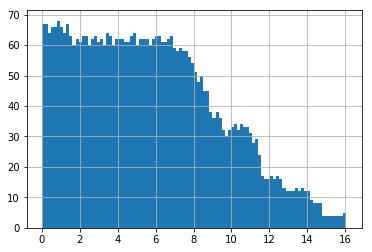

In [12]:
traintest.ydf.hist(bins=100);

In [13]:
np.abs(traintest.ydf-traintest.ydf.median()).mean()

3.032763197384022

In [14]:
testdf=traintest.get_test_data()
testdf.shape

(2624, 100)

In [15]:
data=traintest.traindf
data.head()

fwv_0     fwv_1     fwv_2     fwv_3     fwv_4     fwv_5  \
index                                                                       
quake_07_0405  0.177243  0.148722  0.101298 -0.151453  0.118340  0.085533   
quake_07_0404  0.175916  0.208865  0.121425 -0.149945  0.078927 -0.033455   
quake_07_0159  0.123625  0.259964  0.114662 -0.177983  0.076714 -0.008650   
quake_07_0158  0.127892  0.236912  0.120239 -0.147701  0.065033 -0.029501   
quake_07_0401  0.168152  0.240921  0.146662 -0.184900  0.126381  0.005611   

                  fwv_6     fwv_7     fwv_8     fwv_9  ...    fwv_90  \
index                                                  ...             
quake_07_0405 -0.126488  0.383367  0.184891 -0.182000  ...  0.179080   
quake_07_0404 -0.001732  0.259981  0.170118 -0.146734  ...  0.115216   
quake_07_0159  0.029887  0.234569  0.166675 -0.139920  ...  0.126965   
quake_07_0158  0.007605  0.238272  0.166551 -0.104213  ...  0.100541   
quake_07_0401  0.008869  0.288528  0.169460 -0.190870  ...  0.106375   

                 fwv_91    fwv_92    fwv_93    fwv_94    fwv_95    fwv_96  \
index                                                                       
quake_07_0405  0.276661 -0.040588 -0.079376 -0.185854  0.031153  0.011661   
quake_07_0404  0.182124  0.020085  0.007380 -0.045135  0.012951  0.022898   
quake_07_0159  0.131131  0.068873  0.045272  0.115157  0.038833  0.072388   
quake_07_0158  0.158076  0.011800  0.050090  0.066010  0.055765  0.051091   
quake_07_0401  0.173906  0.000818  0.020374 -0.018780  0.006945  0.040418   

                 fwv_97    fwv_98    fwv_99  
index                                        
quake_07_0405 -0.177359  0.021507  0.143021  
quake_07_0404 -0.136806  0.015471  0.179152  
quake_07_0159 -0.109722 -0.035507  0.092227  
quake_07_0158 -0.113880  0.000226  0.118060  
quake_07_0401 -0.139294 -0.030202  0.189248  

[5 rows x 100 columns]

In [16]:
ydf=traintest.ydf
ydf.head()

index
quake_07_0405    0.287999
quake_07_0404    0.327298
quake_07_0159    9.873498
quake_07_0158    9.912896
quake_07_0401    0.444397
Name: y, dtype: float64

In [17]:
qdf=pd.DataFrame(data.index.map(lambda u: u.split("_")[1]).astype(np.int8),index=data.index)
qdf.head()

index
index               
quake_07_0405      7
quake_07_0404      7
quake_07_0159      7
quake_07_0158      7
quake_07_0401      7

In [18]:
qdf['index'].value_counts().to_frame().sort_index().T

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
index  37  296  363  227  325  206  181  413  202  247  293  282  226  219   

        14   15  16  
index  378  242  47

In [19]:
qlen=qdf['index'].value_counts().to_dict()
qlen

{0: 37,
 1: 296,
 2: 363,
 3: 227,
 4: 325,
 5: 206,
 6: 181,
 7: 413,
 8: 202,
 9: 247,
 10: 293,
 11: 282,
 12: 226,
 13: 219,
 14: 378,
 15: 242,
 16: 47}

In [28]:
quakes=set(qdf['index'])
quakes.remove(0)
quakes.remove(16)
quakes

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [29]:
import utils
n_thread= utils.get_num_thread()
n_thread

3

In [31]:
def train_quake(qno1,qno2,params,n_thread):
    if qno1==qno2: return np.nan,np.nan
    assert (qno1 in quakes)
    assert (qno2 in quakes)
    print 'valid quake', qno2, 'train quake', qno1
    teidx=qdf['index']==qno2
    tridx=qdf['index']==qno1
    
    Xtr,ytr,Xte,yte=data[tridx],ydf[tridx],data[teidx],ydf[teidx],
    #display(Xtr)
    Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
    print Xtr.shape,ytr.shape,Xte.shape,yte.shape
    model = lgb.LGBMRegressor(n_estimators = 1500, n_jobs = n_thread, **params)
    model.fit(Xtr, ytr, 
                    eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                    verbose=50, early_stopping_rounds=200)
    return model.best_score['valid_1']['l1'], model.best_iteration

In [32]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [33]:
validScores={}
for qno1 in quakes:
    for qno2 in quakes:
        s=train_quake(qno1, qno2, params,n_thread)
        print "quake ", qno1, qno2, s
        validScores[(qno1,qno2)]=s

quake  1 1 (nan, nan)
valid quake 2 train quake 1
(296, 100) (296,) (363, 100) (363,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.83831	valid_1's l1: 2.91001
[100]	training's l1: 1.53229	valid_1's l1: 2.82107
[150]	training's l1: 1.36123	valid_1's l1: 2.78412
[200]	training's l1: 1.24448	valid_1's l1: 2.77499
[250]	training's l1: 1.17841	valid_1's l1: 2.75546
[300]	training's l1: 1.13763	valid_1's l1: 2.71587
[350]	training's l1: 1.10466	valid_1's l1: 2.71476
[400]	training's l1: 1.08061	valid_1's l1: 2.70708
[450]	training's l1: 1.06185	valid_1's l1: 2.7109
[500]	training's l1: 1.04884	valid_1's l1: 2.70557
[550]	training's l1: 1.03785	valid_1's l1: 2.70001
[600]	training's l1: 1.02671	valid_1's l1: 2.7063
[650]	training's l1: 1.01935	valid_1's l1: 2.68927
[700]	training's l1: 1.01123	valid_1's l1: 2.69855
[750]	training's l1: 1.00335	valid_1's l1: 2.6899
[800]	training's l1: 0.996229	valid_1's l1: 2.68431
[850]	training's l1: 0.989763	valid_1'

[550]	training's l1: 1.03785	valid_1's l1: 1.68642
[600]	training's l1: 1.02671	valid_1's l1: 1.68558
[650]	training's l1: 1.01935	valid_1's l1: 1.69098
[700]	training's l1: 1.01123	valid_1's l1: 1.68432
[750]	training's l1: 1.00335	valid_1's l1: 1.68139
[800]	training's l1: 0.996229	valid_1's l1: 1.67933
[850]	training's l1: 0.989763	valid_1's l1: 1.67986
[900]	training's l1: 0.982817	valid_1's l1: 1.66605
[950]	training's l1: 0.977895	valid_1's l1: 1.66666
[1000]	training's l1: 0.973344	valid_1's l1: 1.67284
[1050]	training's l1: 0.968243	valid_1's l1: 1.67862
[1100]	training's l1: 0.961767	valid_1's l1: 1.67919
Early stopping, best iteration is:
[915]	training's l1: 0.980694	valid_1's l1: 1.66321
quake  1 12 (1.6632098825021728, 915)
valid quake 13 train quake 1
(296, 100) (296,) (219, 100) (219,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.83831	valid_1's l1: 2.32378
[100]	training's l1: 1.53229	valid_1's l1: 2.25934
[150]	training's l1: 1.3

[300]	training's l1: 1.29707	valid_1's l1: 2.43012
[350]	training's l1: 1.27137	valid_1's l1: 2.40833
[400]	training's l1: 1.24831	valid_1's l1: 2.41877
[450]	training's l1: 1.23398	valid_1's l1: 2.41124
[500]	training's l1: 1.21851	valid_1's l1: 2.41233
Early stopping, best iteration is:
[345]	training's l1: 1.27289	valid_1's l1: 2.406
quake  2 11 (2.405999155055886, 345)
valid quake 12 train quake 2
(363, 100) (363,) (226, 100) (226,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.13121	valid_1's l1: 4.21172
[100]	training's l1: 1.73306	valid_1's l1: 4.33989
[150]	training's l1: 1.52607	valid_1's l1: 4.37369
[200]	training's l1: 1.4012	valid_1's l1: 4.25884
Early stopping, best iteration is:
[1]	training's l1: 3.47911	valid_1's l1: 3.05286
quake  2 12 (3.0528605187487807, 1)
valid quake 13 train quake 2
(363, 100) (363,) (219, 100) (219,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.13121	valid_1's l1: 4.52

Early stopping, best iteration is:
[195]	training's l1: 0.963009	valid_1's l1: 4.51761
quake  3 7 (4.517613282829602, 195)
valid quake 8 train quake 3
(227, 100) (227,) (202, 100) (202,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.46274	valid_1's l1: 1.46428
[100]	training's l1: 1.1764	valid_1's l1: 1.31578
[150]	training's l1: 1.03775	valid_1's l1: 1.27846
[200]	training's l1: 0.957192	valid_1's l1: 1.25895
[250]	training's l1: 0.910306	valid_1's l1: 1.21337
[300]	training's l1: 0.871649	valid_1's l1: 1.20058
[350]	training's l1: 0.847774	valid_1's l1: 1.18551
[400]	training's l1: 0.825182	valid_1's l1: 1.15622
[450]	training's l1: 0.80912	valid_1's l1: 1.15789
[500]	training's l1: 0.797153	valid_1's l1: 1.14899
[550]	training's l1: 0.787152	valid_1's l1: 1.14948
[600]	training's l1: 0.779233	valid_1's l1: 1.14475
[650]	training's l1: 0.774019	valid_1's l1: 1.13903
[700]	training's l1: 0.768456	valid_1's l1: 1.1475
[750]	training's l1: 0.762925

[800]	training's l1: 0.934269	valid_1's l1: 1.76845
[850]	training's l1: 0.924906	valid_1's l1: 1.76473
[900]	training's l1: 0.916787	valid_1's l1: 1.76487
[950]	training's l1: 0.909421	valid_1's l1: 1.76749
[1000]	training's l1: 0.902054	valid_1's l1: 1.76891
[1050]	training's l1: 0.894587	valid_1's l1: 1.76917
Early stopping, best iteration is:
[870]	training's l1: 0.920969	valid_1's l1: 1.76261
quake  4 1 (1.7626079154605656, 870)
valid quake 2 train quake 4
(325, 100) (325,) (363, 100) (363,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.71338	valid_1's l1: 2.72944
[100]	training's l1: 1.4222	valid_1's l1: 2.54612
[150]	training's l1: 1.25842	valid_1's l1: 2.39335
[200]	training's l1: 1.17843	valid_1's l1: 2.30593
[250]	training's l1: 1.12649	valid_1's l1: 2.22333
[300]	training's l1: 1.0894	valid_1's l1: 2.18661
[350]	training's l1: 1.06258	valid_1's l1: 2.15705
[400]	training's l1: 1.0425	valid_1's l1: 2.13679
[450]	training's l1: 1.02585	va

[700]	training's l1: 0.955315	valid_1's l1: 2.76821
[750]	training's l1: 0.945926	valid_1's l1: 2.75423
[800]	training's l1: 0.934269	valid_1's l1: 2.75764
[850]	training's l1: 0.924906	valid_1's l1: 2.74826
[900]	training's l1: 0.916787	valid_1's l1: 2.74571
[950]	training's l1: 0.909421	valid_1's l1: 2.75526
[1000]	training's l1: 0.902054	valid_1's l1: 2.75488
[1050]	training's l1: 0.894587	valid_1's l1: 2.75976
Early stopping, best iteration is:
[870]	training's l1: 0.920969	valid_1's l1: 2.74004
quake  4 14 (2.740041160468068, 870)
valid quake 15 train quake 4
(325, 100) (325,) (242, 100) (242,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.71338	valid_1's l1: 1.87106
[100]	training's l1: 1.4222	valid_1's l1: 1.80945
[150]	training's l1: 1.25842	valid_1's l1: 1.81067
[200]	training's l1: 1.17843	valid_1's l1: 1.81313
[250]	training's l1: 1.12649	valid_1's l1: 1.81836
[300]	training's l1: 1.0894	valid_1's l1: 1.81503
Early stopping, best iterat

[200]	training's l1: 0.890783	valid_1's l1: 1.24993
[250]	training's l1: 0.84094	valid_1's l1: 1.2119
[300]	training's l1: 0.811201	valid_1's l1: 1.19751
[350]	training's l1: 0.789802	valid_1's l1: 1.18215
[400]	training's l1: 0.773551	valid_1's l1: 1.17187
[450]	training's l1: 0.761702	valid_1's l1: 1.17949
[500]	training's l1: 0.751789	valid_1's l1: 1.18055
[550]	training's l1: 0.743591	valid_1's l1: 1.1762
[600]	training's l1: 0.736502	valid_1's l1: 1.16964
[650]	training's l1: 0.730416	valid_1's l1: 1.17263
[700]	training's l1: 0.724838	valid_1's l1: 1.17501
[750]	training's l1: 0.71909	valid_1's l1: 1.1768
[800]	training's l1: 0.715179	valid_1's l1: 1.17296
[850]	training's l1: 0.71082	valid_1's l1: 1.17526
[900]	training's l1: 0.707766	valid_1's l1: 1.17849
[950]	training's l1: 0.705075	valid_1's l1: 1.17323
Early stopping, best iteration is:
[770]	training's l1: 0.717232	valid_1's l1: 1.16809
quake  5 12 (1.1680940280030003, 770)
valid quake 13 train quake 5
(206, 100) (206,) (2

[100]	training's l1: 1.93167	valid_1's l1: 2.9908
[150]	training's l1: 1.78913	valid_1's l1: 3.00203
[200]	training's l1: 1.7164	valid_1's l1: 2.99104
Early stopping, best iteration is:
[22]	training's l1: 2.85911	valid_1's l1: 2.9042
quake  7 1 (2.9041957999325136, 22)
valid quake 2 train quake 7
(413, 100) (413,) (363, 100) (363,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.2773	valid_1's l1: 2.26808
[100]	training's l1: 1.93167	valid_1's l1: 1.99272
[150]	training's l1: 1.78913	valid_1's l1: 1.92203
[200]	training's l1: 1.7164	valid_1's l1: 1.88312
[250]	training's l1: 1.66572	valid_1's l1: 1.86676
[300]	training's l1: 1.6321	valid_1's l1: 1.84678
[350]	training's l1: 1.60369	valid_1's l1: 1.8497
[400]	training's l1: 1.5804	valid_1's l1: 1.84898
[450]	training's l1: 1.55715	valid_1's l1: 1.84994
[500]	training's l1: 1.53473	valid_1's l1: 1.85023
Early stopping, best iteration is:
[310]	training's l1: 1.62621	valid_1's l1: 1.84166
quake  7 2 (

[450]	training's l1: 0.688796	valid_1's l1: 1.32694
[500]	training's l1: 0.68117	valid_1's l1: 1.31417
[550]	training's l1: 0.674337	valid_1's l1: 1.29499
[600]	training's l1: 0.66826	valid_1's l1: 1.28972
[650]	training's l1: 0.664076	valid_1's l1: 1.29387
[700]	training's l1: 0.661857	valid_1's l1: 1.29018
[750]	training's l1: 0.657506	valid_1's l1: 1.29436
[800]	training's l1: 0.654446	valid_1's l1: 1.29559
Early stopping, best iteration is:
[605]	training's l1: 0.667778	valid_1's l1: 1.28565
quake  8 3 (1.2856535348941251, 605)
valid quake 4 train quake 8
(202, 100) (202,) (325, 100) (325,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.34775	valid_1's l1: 3.39849
[100]	training's l1: 1.08248	valid_1's l1: 3.39725
[150]	training's l1: 0.933473	valid_1's l1: 3.43898
[200]	training's l1: 0.832482	valid_1's l1: 3.44946
[250]	training's l1: 0.773384	valid_1's l1: 3.47066
Early stopping, best iteration is:
[70]	training's l1: 1.22105	valid_1's l1: 3

[250]	training's l1: 0.773384	valid_1's l1: 1.69017
[300]	training's l1: 0.739607	valid_1's l1: 1.67973
[350]	training's l1: 0.716512	valid_1's l1: 1.66604
[400]	training's l1: 0.699517	valid_1's l1: 1.67681
[450]	training's l1: 0.688796	valid_1's l1: 1.66842
[500]	training's l1: 0.68117	valid_1's l1: 1.67762
Early stopping, best iteration is:
[335]	training's l1: 0.722824	valid_1's l1: 1.65827
quake  8 15 (1.6582722909524679, 335)
valid quake 1 train quake 9
(247, 100) (247,) (296, 100) (296,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.56954	valid_1's l1: 2.46898
[100]	training's l1: 1.25126	valid_1's l1: 2.24489
[150]	training's l1: 1.08041	valid_1's l1: 2.11322
[200]	training's l1: 0.995905	valid_1's l1: 2.04544
[250]	training's l1: 0.937373	valid_1's l1: 2.00542
[300]	training's l1: 0.893999	valid_1's l1: 1.97989
[350]	training's l1: 0.861633	valid_1's l1: 1.95789
[400]	training's l1: 0.839153	valid_1's l1: 1.93611
[450]	training's l1: 0.82

[700]	training's l1: 0.76568	valid_1's l1: 1.51893
[750]	training's l1: 0.758034	valid_1's l1: 1.51522
[800]	training's l1: 0.751758	valid_1's l1: 1.51008
[850]	training's l1: 0.746783	valid_1's l1: 1.51202
[900]	training's l1: 0.743243	valid_1's l1: 1.51355
[950]	training's l1: 0.738545	valid_1's l1: 1.51401
[1000]	training's l1: 0.73362	valid_1's l1: 1.51542
Early stopping, best iteration is:
[830]	training's l1: 0.748753	valid_1's l1: 1.5083
quake  9 11 (1.508299687748254, 830)
valid quake 12 train quake 9
(247, 100) (247,) (226, 100) (226,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.56954	valid_1's l1: 1.50758
[100]	training's l1: 1.25126	valid_1's l1: 1.26209
[150]	training's l1: 1.08041	valid_1's l1: 1.14385
[200]	training's l1: 0.995905	valid_1's l1: 1.11267
[250]	training's l1: 0.937373	valid_1's l1: 1.11129
[300]	training's l1: 0.893999	valid_1's l1: 1.13582
[350]	training's l1: 0.861633	valid_1's l1: 1.14255
[400]	training's l1: 0.839

[250]	training's l1: 1.09596	valid_1's l1: 3.23048
[300]	training's l1: 1.07012	valid_1's l1: 3.19698
[350]	training's l1: 1.05133	valid_1's l1: 3.19224
[400]	training's l1: 1.03682	valid_1's l1: 3.1887
[450]	training's l1: 1.02208	valid_1's l1: 3.19823
[500]	training's l1: 1.01303	valid_1's l1: 3.2078
[550]	training's l1: 1.00488	valid_1's l1: 3.1991
[600]	training's l1: 0.996798	valid_1's l1: 3.19471
Early stopping, best iteration is:
[400]	training's l1: 1.03682	valid_1's l1: 3.1887
quake  10 7 (3.1886983863344014, 400)
valid quake 8 train quake 10
(293, 100) (293,) (202, 100) (202,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.72376	valid_1's l1: 2.76659
[100]	training's l1: 1.39775	valid_1's l1: 2.96622
[150]	training's l1: 1.2266	valid_1's l1: 3.08379
[200]	training's l1: 1.13544	valid_1's l1: 3.1669
Early stopping, best iteration is:
[4]	training's l1: 2.65	valid_1's l1: 2.34387
quake  10 8 (2.343873677074947, 4)
valid quake 9 train quake 

[50]	training's l1: 1.72143	valid_1's l1: 1.95357
[100]	training's l1: 1.39201	valid_1's l1: 1.83435
[150]	training's l1: 1.21659	valid_1's l1: 1.80605
[200]	training's l1: 1.11112	valid_1's l1: 1.82172
[250]	training's l1: 1.05003	valid_1's l1: 1.83106
[300]	training's l1: 1.01009	valid_1's l1: 1.84465
[350]	training's l1: 0.982921	valid_1's l1: 1.87918
Early stopping, best iteration is:
[154]	training's l1: 1.20677	valid_1's l1: 1.80376
quake  11 3 (1.803758450304692, 154)
valid quake 4 train quake 11
(282, 100) (282,) (325, 100) (325,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.72143	valid_1's l1: 2.28013
[100]	training's l1: 1.39201	valid_1's l1: 1.98329
[150]	training's l1: 1.21659	valid_1's l1: 1.84248
[200]	training's l1: 1.11112	valid_1's l1: 1.74609
[250]	training's l1: 1.05003	valid_1's l1: 1.6905
[300]	training's l1: 1.01009	valid_1's l1: 1.65632
[350]	training's l1: 0.982921	valid_1's l1: 1.62069
[400]	training's l1: 0.963255	valid_

quake  11 14 (3.0075877631198824, 520)
valid quake 15 train quake 11
(282, 100) (282,) (242, 100) (242,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.72143	valid_1's l1: 1.64946
[100]	training's l1: 1.39201	valid_1's l1: 1.47507
[150]	training's l1: 1.21659	valid_1's l1: 1.42257
[200]	training's l1: 1.11112	valid_1's l1: 1.37315
[250]	training's l1: 1.05003	valid_1's l1: 1.38197
[300]	training's l1: 1.01009	valid_1's l1: 1.37555
[350]	training's l1: 0.982921	valid_1's l1: 1.3459
[400]	training's l1: 0.963255	valid_1's l1: 1.35891
[450]	training's l1: 0.949841	valid_1's l1: 1.362
[500]	training's l1: 0.939327	valid_1's l1: 1.39002
Early stopping, best iteration is:
[335]	training's l1: 0.988298	valid_1's l1: 1.33809
quake  11 15 (1.3380940128972296, 335)
valid quake 1 train quake 12
(226, 100) (226,) (296, 100) (296,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.44786	valid_1's l1: 2.70509
[100]	training's l

quake  12 9 (1.2148187212646, 730)
valid quake 10 train quake 12
(226, 100) (226,) (293, 100) (293,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.44786	valid_1's l1: 2.56389
[100]	training's l1: 1.15585	valid_1's l1: 2.38213
[150]	training's l1: 1.00306	valid_1's l1: 2.2857
[200]	training's l1: 0.909998	valid_1's l1: 2.22743
[250]	training's l1: 0.857969	valid_1's l1: 2.19191
[300]	training's l1: 0.81805	valid_1's l1: 2.17125
[350]	training's l1: 0.792014	valid_1's l1: 2.16055
[400]	training's l1: 0.771597	valid_1's l1: 2.15008
[450]	training's l1: 0.754687	valid_1's l1: 2.15083
[500]	training's l1: 0.744416	valid_1's l1: 2.15448
[550]	training's l1: 0.733682	valid_1's l1: 2.13872
[600]	training's l1: 0.725285	valid_1's l1: 2.13819
[650]	training's l1: 0.717328	valid_1's l1: 2.14512
[700]	training's l1: 0.709704	valid_1's l1: 2.146
[750]	training's l1: 0.703736	valid_1's l1: 2.13875
[800]	training's l1: 0.699451	valid_1's l1: 2.14109
[850]	traini

[250]	training's l1: 0.949171	valid_1's l1: 0.973875
[300]	training's l1: 0.92297	valid_1's l1: 0.950192
[350]	training's l1: 0.897401	valid_1's l1: 0.93218
[400]	training's l1: 0.877789	valid_1's l1: 0.923504
[450]	training's l1: 0.861385	valid_1's l1: 0.91846
[500]	training's l1: 0.846889	valid_1's l1: 0.914191
[550]	training's l1: 0.833041	valid_1's l1: 0.905123
[600]	training's l1: 0.821077	valid_1's l1: 0.899248
[650]	training's l1: 0.810676	valid_1's l1: 0.891562
[700]	training's l1: 0.800836	valid_1's l1: 0.889891
[750]	training's l1: 0.794051	valid_1's l1: 0.885606
[800]	training's l1: 0.786557	valid_1's l1: 0.882205
[850]	training's l1: 0.780623	valid_1's l1: 0.881246
[900]	training's l1: 0.774876	valid_1's l1: 0.880566
[950]	training's l1: 0.769365	valid_1's l1: 0.881788
[1000]	training's l1: 0.765211	valid_1's l1: 0.881443
[1050]	training's l1: 0.759153	valid_1's l1: 0.879849
Early stopping, best iteration is:
[890]	training's l1: 0.775998	valid_1's l1: 0.879376
quake  13 5 

Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.19677	valid_1's l1: 3.09877
[100]	training's l1: 1.83412	valid_1's l1: 3.21731
[150]	training's l1: 1.66081	valid_1's l1: 3.18418
[200]	training's l1: 1.55491	valid_1's l1: 3.10026
Early stopping, best iteration is:
[17]	training's l1: 2.75752	valid_1's l1: 2.8956
quake  14 1 (2.895600229694075, 17)
valid quake 2 train quake 14
(378, 100) (378,) (363, 100) (363,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.19677	valid_1's l1: 2.51746
[100]	training's l1: 1.83412	valid_1's l1: 2.26611
[150]	training's l1: 1.66081	valid_1's l1: 2.03223
[200]	training's l1: 1.55491	valid_1's l1: 1.85621
[250]	training's l1: 1.48664	valid_1's l1: 1.80276
[300]	training's l1: 1.44488	valid_1's l1: 1.76513
[350]	training's l1: 1.41943	valid_1's l1: 1.73763
[400]	training's l1: 1.39871	valid_1's l1: 1.72353
[450]	training's l1: 1.37765	valid_1's l1: 1.72701
[500]	training's l1: 1.36022

[400]	training's l1: 0.835529	valid_1's l1: 1.04316
[450]	training's l1: 0.826175	valid_1's l1: 1.03599
[500]	training's l1: 0.817477	valid_1's l1: 1.03813
[550]	training's l1: 0.808866	valid_1's l1: 1.03608
[600]	training's l1: 0.799868	valid_1's l1: 1.03946
[650]	training's l1: 0.792409	valid_1's l1: 1.04169
[700]	training's l1: 0.786112	valid_1's l1: 1.04199
Early stopping, best iteration is:
[535]	training's l1: 0.811678	valid_1's l1: 1.03487
quake  15 5 (1.034870295372186, 535)
valid quake 6 train quake 15
(242, 100) (242,) (181, 100) (181,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.52246	valid_1's l1: 1.57943
[100]	training's l1: 1.20018	valid_1's l1: 1.47987
[150]	training's l1: 1.03497	valid_1's l1: 1.4421
[200]	training's l1: 0.95064	valid_1's l1: 1.4018
[250]	training's l1: 0.898858	valid_1's l1: 1.38745
[300]	training's l1: 0.866103	valid_1's l1: 1.38695
[350]	training's l1: 0.848354	valid_1's l1: 1.38776
[400]	training's l1: 0.8355

In [34]:
vdf=pd.DataFrame(validScores).T.dropna().reset_index()
vdf.columns=['q1','q2','score','round']
vdf['round']=vdf['round'].astype(np.int)
vdf=vdf.sort_values('score')

In [35]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

In [36]:
pvdf=vdf.pivot_table(values='score',index='q1',columns='q2').round(2)

In [37]:
pvdf.style.apply(highlight_max,axis=1)

In [38]:
pvdf.style.apply(highlight_min,axis=1)

The orignal folds is [[ 9,  4,  6] , [15,  1,  5], [10, 14,  3],  [7, 11,  2],  [8, 13, 12]], fold 3 is of all hard parts.

In [39]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

#pvdf.fillna(0).style.background_gradient(cmap='viridis')
display(pvdf.fillna(pvdf.median().median()).style.background_gradient(cmap=cm,axis=0))
display(pvdf.fillna(pvdf.median().median()).style.background_gradient(cmap=cm,axis=1))

### let us use another feature

In [40]:
if 1:
    import data
    strategy = {'type':'rand', "fold":5}
    types=['kaggle']
    traintest = data.TrainTest('offset', offset=0, types=types, transform=None, valid_strategy=strategy)


In [41]:
data=traintest.traindf
data.head()

mean         std     max     min  mean_change_abs  \
index                                                                  
quake_07_0405  4.754687  112.403053  3449.0 -4482.0        -0.000040   
quake_07_0404  4.388320    7.992427   197.0  -150.0        -0.000133   
quake_07_0159  4.163873    5.355352    94.0  -100.0         0.000000   
quake_07_0158  4.337180    8.291819   225.0  -303.0        -0.000013   
quake_07_0401  4.253860    9.357168   163.0  -180.0        -0.000027   

               mean_change_rate  abs_max  abs_min  std_first_50000  \
index                                                                
quake_07_0405      74808.265625   4482.0      0.0       192.340714   
quake_07_0404      74927.109375    197.0      0.0         8.026689   
quake_07_0159      75064.226562    100.0      0.0         5.043597   
quake_07_0158      74872.507812    303.0      0.0         7.850916   
quake_07_0401      74872.679688    180.0      0.0        11.967152   

               std_last_50000  ...  std_roll_mean_1000  max_roll_mean_1000  \
index                          ...                                           
quake_07_0405       10.274352  ...            3.231018           60.556999   
quake_07_0404        5.546714  ...            0.248627            5.298000   
quake_07_0159        5.753076  ...            0.220619            4.855000   
quake_07_0158        5.251257  ...            0.198317            5.391000   
quake_07_0401        8.482751  ...            0.298184            5.484000   

               min_roll_mean_1000  q01_roll_mean_1000  q05_roll_mean_1000  \
index                                                                       
quake_07_0405          -37.478001              -4.641               2.239   
quake_07_0404            3.267000               3.745               3.942   
quake_07_0159            3.385000               3.551               3.779   
quake_07_0158            2.926000               3.816               3.994   
quake_07_0401            3.068000               3.614               3.813   

               q95_roll_mean_1000  q99_roll_mean_1000  \
index                                                   
quake_07_0405               7.226              10.811   
quake_07_0404               4.788               4.941   
quake_07_0159               4.500               4.580   
quake_07_0158               4.628               4.753   
quake_07_0401               4.780               4.915   

               av_change_abs_roll_mean_1000  av_change_rate_roll_mean_1000  \
index                                                                        
quake_07_0405                      0.000002                   74515.828125   
quake_07_0404                      0.000001                   74398.226562   
quake_07_0159                     -0.000002                   74622.101562   
quake_07_0158                     -0.000003                   74331.937500   
quake_07_0401                      0.000003                   74397.429688   

               abs_max_roll_mean_1000  
index                                  
quake_07_0405               60.556999  
quake_07_0404                5.298000  
quake_07_0159                4.855000  
quake_07_0158                5.391000  
quake_07_0401                5.484000  

[5 rows x 137 columns]

In [42]:
ydf=traintest.ydf
ydf.head()

index
quake_07_0405    0.287999
quake_07_0404    0.327298
quake_07_0159    9.873498
quake_07_0158    9.912896
quake_07_0401    0.444397
Name: y, dtype: float64

In [43]:
qdf=pd.DataFrame(data.index.map(lambda u: u.split("_")[1]).astype(np.int8),index=data.index)
qdf.head()

index
index               
quake_07_0405      7
quake_07_0404      7
quake_07_0159      7
quake_07_0158      7
quake_07_0401      7

In [44]:
qdf['index'].value_counts().to_frame().sort_index().T

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
index  37  296  363  227  325  206  181  413  202  247  293  282  226  219   

        14   15  16  
index  378  242  47

In [45]:
qlen=qdf['index'].value_counts().to_dict()
qlen

{0: 37,
 1: 296,
 2: 363,
 3: 227,
 4: 325,
 5: 206,
 6: 181,
 7: 413,
 8: 202,
 9: 247,
 10: 293,
 11: 282,
 12: 226,
 13: 219,
 14: 378,
 15: 242,
 16: 47}

In [46]:
#quakes=set(qdf['index'])
quakes

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [47]:
import utils
n_thread= utils.get_num_thread()
n_thread

3

In [48]:
def train_quake(qno1,qno2,params,n_thread):
    if qno1==qno2: return np.nan,np.nan
    assert (qno1 in quakes)
    assert (qno2 in quakes)
    print 'valid quake', qno2, 'train quake', qno1
    teidx=qdf['index']==qno2
    tridx=qdf['index']==qno1
    
    Xtr,ytr,Xte,yte=data[tridx],ydf[tridx],data[teidx],ydf[teidx],
    Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
    print Xtr.shape,ytr.shape,Xte.shape,yte.shape
    model = lgb.LGBMRegressor(n_estimators = 1500, n_jobs = n_thread, **params)
    model.fit(Xtr, ytr, 
                    eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                    verbose=50, early_stopping_rounds=200)
    return model.best_score['valid_1']['l1'], model.best_iteration

In [49]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [50]:
validScores={}
for qno1 in quakes:
    for qno2 in quakes:
        s=train_quake(qno1, qno2, params,n_thread)
        print "quake ", qno1, qno2, s
        validScores[(qno1,qno2)]=s

quake  1 1 (nan, nan)
valid quake 2 train quake 1
(296, 137) (296,) (363, 137) (363,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.90171	valid_1's l1: 2.95843
[100]	training's l1: 1.62242	valid_1's l1: 2.79594
[150]	training's l1: 1.46946	valid_1's l1: 2.71991
[200]	training's l1: 1.36013	valid_1's l1: 2.68832
[250]	training's l1: 1.3042	valid_1's l1: 2.70758
[300]	training's l1: 1.26688	valid_1's l1: 2.69887
[350]	training's l1: 1.24069	valid_1's l1: 2.71405
[400]	training's l1: 1.21833	valid_1's l1: 2.71803
Early stopping, best iteration is:
[207]	training's l1: 1.34936	valid_1's l1: 2.68657
quake  1 2 (2.6865654886391455, 207)
valid quake 3 train quake 1
(296, 137) (296,) (227, 137) (227,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.90171	valid_1's l1: 1.91073
[100]	training's l1: 1.62242	valid_1's l1: 1.78652
[150]	training's l1: 1.46946	valid_1's l1: 1.70471
[200]	training's l1: 1.36013	valid_1's l1: 

[100]	training's l1: 1.62242	valid_1's l1: 1.94632
[150]	training's l1: 1.46946	valid_1's l1: 1.88566
[200]	training's l1: 1.36013	valid_1's l1: 1.82855
[250]	training's l1: 1.3042	valid_1's l1: 1.83219
[300]	training's l1: 1.26688	valid_1's l1: 1.85252
[350]	training's l1: 1.24069	valid_1's l1: 1.87954
[400]	training's l1: 1.21833	valid_1's l1: 1.8841
Early stopping, best iteration is:
[220]	training's l1: 1.33453	valid_1's l1: 1.82261
quake  1 15 (1.822608868817819, 220)
valid quake 1 train quake 2
(363, 137) (363,) (296, 137) (296,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.14017	valid_1's l1: 2.75289
[100]	training's l1: 1.7049	valid_1's l1: 2.82951
[150]	training's l1: 1.52037	valid_1's l1: 2.95147
[200]	training's l1: 1.42695	valid_1's l1: 3.03674
Early stopping, best iteration is:
[18]	training's l1: 2.65466	valid_1's l1: 2.69884
quake  2 1 (2.698838544092928, 18)
quake  2 2 (nan, nan)
valid quake 3 train quake 2
(363, 137) (363,) (227,

[700]	training's l1: 0.830436	valid_1's l1: 2.15902
[750]	training's l1: 0.824946	valid_1's l1: 2.15992
[800]	training's l1: 0.821044	valid_1's l1: 2.15886
Early stopping, best iteration is:
[640]	training's l1: 0.837245	valid_1's l1: 2.1525
quake  3 1 (2.1524955443637914, 640)
valid quake 2 train quake 3
(227, 137) (227,) (363, 137) (363,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.47986	valid_1's l1: 3.70017
[100]	training's l1: 1.19375	valid_1's l1: 3.5721
[150]	training's l1: 1.05145	valid_1's l1: 3.50762
[200]	training's l1: 0.983417	valid_1's l1: 3.48116
[250]	training's l1: 0.942623	valid_1's l1: 3.47593
[300]	training's l1: 0.914823	valid_1's l1: 3.46942
[350]	training's l1: 0.892997	valid_1's l1: 3.45916
[400]	training's l1: 0.880302	valid_1's l1: 3.45794
[450]	training's l1: 0.869566	valid_1's l1: 3.45578
[500]	training's l1: 0.857822	valid_1's l1: 3.45422
[550]	training's l1: 0.847835	valid_1's l1: 3.44344
[600]	training's l1: 0.8410

[50]	training's l1: 1.47986	valid_1's l1: 2.32963
[100]	training's l1: 1.19375	valid_1's l1: 2.14159
[150]	training's l1: 1.05145	valid_1's l1: 2.03123
[200]	training's l1: 0.983417	valid_1's l1: 1.97914
[250]	training's l1: 0.942623	valid_1's l1: 1.95815
[300]	training's l1: 0.914823	valid_1's l1: 1.94035
[350]	training's l1: 0.892997	valid_1's l1: 1.9163
[400]	training's l1: 0.880302	valid_1's l1: 1.91326
[450]	training's l1: 0.869566	valid_1's l1: 1.90779
[500]	training's l1: 0.857822	valid_1's l1: 1.90811
[550]	training's l1: 0.847835	valid_1's l1: 1.89818
[600]	training's l1: 0.841078	valid_1's l1: 1.89634
[650]	training's l1: 0.836388	valid_1's l1: 1.89245
[700]	training's l1: 0.830436	valid_1's l1: 1.89455
[750]	training's l1: 0.824946	valid_1's l1: 1.89171
[800]	training's l1: 0.821044	valid_1's l1: 1.89531
[850]	training's l1: 0.815578	valid_1's l1: 1.89856
[900]	training's l1: 0.810942	valid_1's l1: 1.90089
[950]	training's l1: 0.806969	valid_1's l1: 1.90702
Early stopping, b

[200]	training's l1: 1.24059	valid_1's l1: 3.07972
[250]	training's l1: 1.19474	valid_1's l1: 3.05736
[300]	training's l1: 1.16549	valid_1's l1: 3.06434
[350]	training's l1: 1.14481	valid_1's l1: 3.07116
[400]	training's l1: 1.12638	valid_1's l1: 3.06812
[450]	training's l1: 1.11189	valid_1's l1: 3.06549
Early stopping, best iteration is:
[280]	training's l1: 1.17527	valid_1's l1: 3.0538
quake  4 7 (3.0538016350397736, 280)
valid quake 8 train quake 4
(325, 137) (325,) (202, 137) (202,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.78928	valid_1's l1: 3.52128
[100]	training's l1: 1.47668	valid_1's l1: 3.68433
[150]	training's l1: 1.31893	valid_1's l1: 3.74316
[200]	training's l1: 1.24059	valid_1's l1: 3.79899
Early stopping, best iteration is:
[1]	training's l1: 3.09309	valid_1's l1: 2.71298
quake  4 8 (2.712984622432335, 1)
valid quake 9 train quake 4
(325, 137) (325,) (247, 137) (247,)
Training until validation scores don't improve for 200 round

[900]	training's l1: 0.781212	valid_1's l1: 1.24107
[950]	training's l1: 0.776894	valid_1's l1: 1.24321
[1000]	training's l1: 0.773279	valid_1's l1: 1.24344
Early stopping, best iteration is:
[840]	training's l1: 0.787134	valid_1's l1: 1.23466
quake  5 3 (1.2346626916809251, 840)
valid quake 4 train quake 5
(206, 137) (206,) (325, 137) (325,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.34948	valid_1's l1: 3.3525
[100]	training's l1: 1.12722	valid_1's l1: 3.29696
[150]	training's l1: 1.01529	valid_1's l1: 3.27306
[200]	training's l1: 0.946854	valid_1's l1: 3.26622
[250]	training's l1: 0.902152	valid_1's l1: 3.26809
[300]	training's l1: 0.87541	valid_1's l1: 3.26557
[350]	training's l1: 0.859494	valid_1's l1: 3.2587
[400]	training's l1: 0.8463	valid_1's l1: 3.2617
[450]	training's l1: 0.83645	valid_1's l1: 3.26154
[500]	training's l1: 0.828516	valid_1's l1: 3.27264
Early stopping, best iteration is:
[340]	training's l1: 0.862636	valid_1's l1: 3.25

[600]	training's l1: 0.812629	valid_1's l1: 1.09978
Early stopping, best iteration is:
[415]	training's l1: 0.843194	valid_1's l1: 1.09425
quake  5 13 (1.09424685037269, 415)
valid quake 14 train quake 5
(206, 137) (206,) (378, 137) (378,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.34948	valid_1's l1: 4.37881
[100]	training's l1: 1.12722	valid_1's l1: 4.40538
[150]	training's l1: 1.01529	valid_1's l1: 4.43728
[200]	training's l1: 0.946854	valid_1's l1: 4.46523
Early stopping, best iteration is:
[25]	training's l1: 1.57563	valid_1's l1: 4.37713
quake  5 14 (4.377134685526177, 25)
valid quake 15 train quake 5
(206, 137) (206,) (242, 137) (242,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.34948	valid_1's l1: 1.91715
[100]	training's l1: 1.12722	valid_1's l1: 1.74901
[150]	training's l1: 1.01529	valid_1's l1: 1.67136
[200]	training's l1: 0.946854	valid_1's l1: 1.62322
[250]	training's l1: 0.902152	valid_1's 

Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.29002	valid_1's l1: 2.08522
[100]	training's l1: 1.9495	valid_1's l1: 1.90058
[150]	training's l1: 1.81886	valid_1's l1: 1.85219
[200]	training's l1: 1.75111	valid_1's l1: 1.81721
[250]	training's l1: 1.70473	valid_1's l1: 1.80525
[300]	training's l1: 1.66958	valid_1's l1: 1.79552
[350]	training's l1: 1.64259	valid_1's l1: 1.78913
[400]	training's l1: 1.61272	valid_1's l1: 1.79134
[450]	training's l1: 1.59227	valid_1's l1: 1.79169
[500]	training's l1: 1.57174	valid_1's l1: 1.78985
[550]	training's l1: 1.54924	valid_1's l1: 1.7941
[600]	training's l1: 1.53015	valid_1's l1: 1.801
[650]	training's l1: 1.51539	valid_1's l1: 1.80207
[700]	training's l1: 1.49877	valid_1's l1: 1.81341
Early stopping, best iteration is:
[505]	training's l1: 1.56932	valid_1's l1: 1.78762
quake  7 2 (1.7876177868775986, 505)
valid quake 3 train quake 7
(413, 137) (413,) (227, 137) (227,)
Training until validation scores don't im

[700]	training's l1: 0.794217	valid_1's l1: 2.85474
[750]	training's l1: 0.789066	valid_1's l1: 2.855
[800]	training's l1: 0.784962	valid_1's l1: 2.86049
[850]	training's l1: 0.780313	valid_1's l1: 2.85556
Early stopping, best iteration is:
[670]	training's l1: 0.796558	valid_1's l1: 2.84976
quake  8 1 (2.8497598100935346, 670)
valid quake 2 train quake 8
(202, 137) (202,) (363, 137) (363,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.36714	valid_1's l1: 4.1644
[100]	training's l1: 1.12097	valid_1's l1: 4.17577
[150]	training's l1: 1.00126	valid_1's l1: 4.18815
[200]	training's l1: 0.936974	valid_1's l1: 4.21005
Early stopping, best iteration is:
[45]	training's l1: 1.40587	valid_1's l1: 4.16013
quake  8 2 (4.160132284384717, 45)
valid quake 3 train quake 8
(202, 137) (202,) (227, 137) (227,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.36714	valid_1's l1: 1.80705
[100]	training's l1: 1.12097	valid_1's l1: 

[900]	training's l1: 0.776959	valid_1's l1: 1.53994
[950]	training's l1: 0.772715	valid_1's l1: 1.53416
[1000]	training's l1: 0.768021	valid_1's l1: 1.52415
[1050]	training's l1: 0.764829	valid_1's l1: 1.53008
[1100]	training's l1: 0.761566	valid_1's l1: 1.53201
[1150]	training's l1: 0.758876	valid_1's l1: 1.53322
[1200]	training's l1: 0.755301	valid_1's l1: 1.5384
Early stopping, best iteration is:
[1005]	training's l1: 0.767494	valid_1's l1: 1.5239
quake  8 15 (1.5238980096097803, 1005)
valid quake 1 train quake 9
(247, 137) (247,) (296, 137) (296,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.5342	valid_1's l1: 2.41332
[100]	training's l1: 1.2257	valid_1's l1: 2.21442
[150]	training's l1: 1.08265	valid_1's l1: 2.08963
[200]	training's l1: 1.00875	valid_1's l1: 2.04305
[250]	training's l1: 0.96103	valid_1's l1: 2.02239
[300]	training's l1: 0.924758	valid_1's l1: 2.00907
[350]	training's l1: 0.897265	valid_1's l1: 1.9994
[400]	training's l1: 0.8

[200]	training's l1: 1.00875	valid_1's l1: 1.66812
[250]	training's l1: 0.96103	valid_1's l1: 1.67419
[300]	training's l1: 0.924758	valid_1's l1: 1.68915
Early stopping, best iteration is:
[109]	training's l1: 1.18934	valid_1's l1: 1.65738
quake  9 8 (1.6573761113439236, 109)
quake  9 9 (nan, nan)
valid quake 10 train quake 9
(247, 137) (247,) (293, 137) (293,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.5342	valid_1's l1: 2.25105
[100]	training's l1: 1.2257	valid_1's l1: 2.0184
[150]	training's l1: 1.08265	valid_1's l1: 1.89004
[200]	training's l1: 1.00875	valid_1's l1: 1.85358
[250]	training's l1: 0.96103	valid_1's l1: 1.83599
[300]	training's l1: 0.924758	valid_1's l1: 1.82863
[350]	training's l1: 0.897265	valid_1's l1: 1.83116
[400]	training's l1: 0.875381	valid_1's l1: 1.83483
[450]	training's l1: 0.856464	valid_1's l1: 1.83945
[500]	training's l1: 0.841603	valid_1's l1: 1.84811
Early stopping, best iteration is:
[320]	training's l1: 0.9116

[100]	training's l1: 1.41704	valid_1's l1: 2.84652
[150]	training's l1: 1.26378	valid_1's l1: 2.87855
[200]	training's l1: 1.18183	valid_1's l1: 2.89601
Early stopping, best iteration is:
[1]	training's l1: 2.79808	valid_1's l1: 2.4499
quake  10 6 (2.4499046368101194, 1)
valid quake 7 train quake 10
(293, 137) (293,) (413, 137) (413,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.74217	valid_1's l1: 3.5879
[100]	training's l1: 1.41704	valid_1's l1: 3.40789
[150]	training's l1: 1.26378	valid_1's l1: 3.29549
[200]	training's l1: 1.18183	valid_1's l1: 3.23993
[250]	training's l1: 1.14826	valid_1's l1: 3.22197
[300]	training's l1: 1.13138	valid_1's l1: 3.2106
[350]	training's l1: 1.11574	valid_1's l1: 3.2023
[400]	training's l1: 1.10312	valid_1's l1: 3.19991
[450]	training's l1: 1.09097	valid_1's l1: 3.20792
[500]	training's l1: 1.0814	valid_1's l1: 3.20589
[550]	training's l1: 1.07107	valid_1's l1: 3.19904
[600]	training's l1: 1.06325	valid_1's l1: 3

[1050]	training's l1: 0.941943	valid_1's l1: 2.42003
[1100]	training's l1: 0.937467	valid_1's l1: 2.41477
[1150]	training's l1: 0.932601	valid_1's l1: 2.41369
[1200]	training's l1: 0.928434	valid_1's l1: 2.40893
[1250]	training's l1: 0.925337	valid_1's l1: 2.40952
[1300]	training's l1: 0.921497	valid_1's l1: 2.40834
[1350]	training's l1: 0.9166	valid_1's l1: 2.40538
[1400]	training's l1: 0.91242	valid_1's l1: 2.40475
[1450]	training's l1: 0.908531	valid_1's l1: 2.40256
[1500]	training's l1: 0.904743	valid_1's l1: 2.40117
quake  11 2 (2.401174666264395, 0)
valid quake 3 train quake 11
(282, 137) (282,) (227, 137) (227,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.7066	valid_1's l1: 1.85866
[100]	training's l1: 1.37949	valid_1's l1: 1.74217
[150]	training's l1: 1.23112	valid_1's l1: 1.71938
[200]	training's l1: 1.15407	valid_1's l1: 1.73997
[250]	training's l1: 1.10825	valid_1's l1: 1.7617
[300]	training's l1: 1.07427	valid_1's l1: 1.77332
Early s

[500]	training's l1: 0.861385	valid_1's l1: 2.21504
[550]	training's l1: 0.850995	valid_1's l1: 2.20887
[600]	training's l1: 0.843754	valid_1's l1: 2.20797
[650]	training's l1: 0.839852	valid_1's l1: 2.2028
[700]	training's l1: 0.83207	valid_1's l1: 2.20105
[750]	training's l1: 0.826829	valid_1's l1: 2.19717
[800]	training's l1: 0.822639	valid_1's l1: 2.19656
[850]	training's l1: 0.818013	valid_1's l1: 2.19841
[900]	training's l1: 0.812541	valid_1's l1: 2.20032
[950]	training's l1: 0.808202	valid_1's l1: 2.2
[1000]	training's l1: 0.805365	valid_1's l1: 2.19416
[1050]	training's l1: 0.802214	valid_1's l1: 2.19423
[1100]	training's l1: 0.799075	valid_1's l1: 2.19319
[1150]	training's l1: 0.794262	valid_1's l1: 2.19055
[1200]	training's l1: 0.79001	valid_1's l1: 2.19056
[1250]	training's l1: 0.787512	valid_1's l1: 2.19166
[1300]	training's l1: 0.78442	valid_1's l1: 2.19161
[1350]	training's l1: 0.78122	valid_1's l1: 2.19274
[1400]	training's l1: 0.777946	valid_1's l1: 2.19473
[1450]	train

[1150]	training's l1: 0.794262	valid_1's l1: 2.15095
[1200]	training's l1: 0.79001	valid_1's l1: 2.15027
[1250]	training's l1: 0.787512	valid_1's l1: 2.15097
[1300]	training's l1: 0.78442	valid_1's l1: 2.15079
[1350]	training's l1: 0.78122	valid_1's l1: 2.15198
[1400]	training's l1: 0.777946	valid_1's l1: 2.15471
[1450]	training's l1: 0.775903	valid_1's l1: 2.15531
Early stopping, best iteration is:
[1265]	training's l1: 0.786274	valid_1's l1: 2.14677
quake  12 10 (2.146770369894078, 1265)
valid quake 11 train quake 12
(226, 137) (226,) (282, 137) (282,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.45132	valid_1's l1: 2.39126
[100]	training's l1: 1.17133	valid_1's l1: 2.21778
[150]	training's l1: 1.04131	valid_1's l1: 2.14138
[200]	training's l1: 0.975403	valid_1's l1: 2.10051
[250]	training's l1: 0.936104	valid_1's l1: 2.0802
[300]	training's l1: 0.911344	valid_1's l1: 2.06745
[350]	training's l1: 0.892705	valid_1's l1: 2.06108
[400]	training's 

[700]	training's l1: 0.879889	valid_1's l1: 2.92296
[750]	training's l1: 0.872988	valid_1's l1: 2.92557
[800]	training's l1: 0.867504	valid_1's l1: 2.92558
[850]	training's l1: 0.862543	valid_1's l1: 2.92293
[900]	training's l1: 0.857487	valid_1's l1: 2.91986
[950]	training's l1: 0.852947	valid_1's l1: 2.90695
[1000]	training's l1: 0.847375	valid_1's l1: 2.90861
[1050]	training's l1: 0.843381	valid_1's l1: 2.90954
[1100]	training's l1: 0.838985	valid_1's l1: 2.91845
[1150]	training's l1: 0.83517	valid_1's l1: 2.91565
Early stopping, best iteration is:
[955]	training's l1: 0.852335	valid_1's l1: 2.90519
quake  13 4 (2.905186886403821, 955)
valid quake 5 train quake 13
(219, 137) (219,) (206, 137) (206,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.43309	valid_1's l1: 1.41396
[100]	training's l1: 1.1922	valid_1's l1: 1.20211
[150]	training's l1: 1.08255	valid_1's l1: 1.10141
[200]	training's l1: 1.02315	valid_1's l1: 1.05143
[250]	training's l1: 0.

[50]	training's l1: 1.43309	valid_1's l1: 4.18338
[100]	training's l1: 1.1922	valid_1's l1: 4.16107
[150]	training's l1: 1.08255	valid_1's l1: 4.15676
[200]	training's l1: 1.02315	valid_1's l1: 4.16512
[250]	training's l1: 0.985174	valid_1's l1: 4.185
[300]	training's l1: 0.962048	valid_1's l1: 4.2047
Early stopping, best iteration is:
[130]	training's l1: 1.11916	valid_1's l1: 4.15204
quake  13 14 (4.152035916201881, 130)
valid quake 15 train quake 13
(219, 137) (219,) (242, 137) (242,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.43309	valid_1's l1: 1.7659
[100]	training's l1: 1.1922	valid_1's l1: 1.49891
[150]	training's l1: 1.08255	valid_1's l1: 1.35578
[200]	training's l1: 1.02315	valid_1's l1: 1.28413
[250]	training's l1: 0.985174	valid_1's l1: 1.24729
[300]	training's l1: 0.962048	valid_1's l1: 1.2299
[350]	training's l1: 0.945381	valid_1's l1: 1.23894
[400]	training's l1: 0.931715	valid_1's l1: 1.24967
[450]	training's l1: 0.920106	valid_

Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.21228	valid_1's l1: 4.78884
[100]	training's l1: 1.86326	valid_1's l1: 4.90153
[150]	training's l1: 1.66678	valid_1's l1: 4.93739
[200]	training's l1: 1.57201	valid_1's l1: 4.96415
Early stopping, best iteration is:
[1]	training's l1: 3.61871	valid_1's l1: 3.2873
quake  14 13 (3.2872974308654768, 1)
quake  14 14 (nan, nan)
valid quake 15 train quake 14
(378, 137) (378,) (242, 137) (242,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.21228	valid_1's l1: 4.25339
[100]	training's l1: 1.86326	valid_1's l1: 4.35238
[150]	training's l1: 1.66678	valid_1's l1: 4.30847
[200]	training's l1: 1.57201	valid_1's l1: 4.30829
Early stopping, best iteration is:
[1]	training's l1: 3.61871	valid_1's l1: 3.10879
quake  14 15 (3.1087863755250873, 1)
valid quake 1 train quake 15
(242, 137) (242,) (296, 137) (296,)
Training until validation scores don't improve for 200 rounds.
[50]	trai

[100]	training's l1: 1.20514	valid_1's l1: 1.22262
[150]	training's l1: 1.05527	valid_1's l1: 1.13868
[200]	training's l1: 0.984852	valid_1's l1: 1.09973
[250]	training's l1: 0.943251	valid_1's l1: 1.08086
[300]	training's l1: 0.920344	valid_1's l1: 1.07
[350]	training's l1: 0.904947	valid_1's l1: 1.06648
[400]	training's l1: 0.89324	valid_1's l1: 1.06087
[450]	training's l1: 0.883321	valid_1's l1: 1.05961
[500]	training's l1: 0.876244	valid_1's l1: 1.06009
[550]	training's l1: 0.870925	valid_1's l1: 1.05769
[600]	training's l1: 0.866261	valid_1's l1: 1.05706
[650]	training's l1: 0.861797	valid_1's l1: 1.06155
[700]	training's l1: 0.856814	valid_1's l1: 1.06293
[750]	training's l1: 0.852391	valid_1's l1: 1.06144
Early stopping, best iteration is:
[590]	training's l1: 0.86688	valid_1's l1: 1.05647
quake  15 13 (1.0564723572004615, 590)
valid quake 14 train quake 15
(242, 137) (242,) (378, 137) (378,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 1.50

In [51]:
vdf=pd.DataFrame(validScores).T.dropna().reset_index()
vdf.columns=['q1','q2','score','round']
vdf['round']=vdf['round'].astype(np.int)
vdf=vdf.sort_values('score')

In [52]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

In [53]:
pvdf=vdf.pivot_table(values='score',index='q1',columns='q2').round(2)

In [54]:
pvdf.style.apply(highlight_max,axis=1)

In [55]:
pvdf.style.apply(highlight_min,axis=1)

In [56]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

#pvdf.fillna(0).style.background_gradient(cmap='viridis')
display(pvdf.fillna(pvdf.median().median()).style.background_gradient(cmap=cm,axis=0))
display(pvdf.fillna(pvdf.median().median()).style.background_gradient(cmap=cm,axis=1))